如果出现读取不了数据文件的问题，将原来的版本删掉，安装新的jaqs_fxdayu：

pip install git+https://github.com/xingetouzi/jaqs-fxdayu.git


**min_data数据下载：**

链接：https://pan.baidu.com/s/1OBTX-zc2GfsGutlEeoznJg 
提取码：uz91 

如果放在同一目录下使用
path = r'./min_data/OANDA_M1'

如果放在不同目录下使用或者指定路径
path = r'../min_data/OANDA_M1'

## 1. 数据的读取

## ds.read_bar

**1) path : hdf5文件上级目录**
    
  '.\min_data\VnTrader_1Min_Db' 与 '.\min_data\OANDA_M1'
  
  binance后缀的品种在VnTrader_1Min_Db、oanda后缀的品种在OANDA_M1的位置

**2) props :**

  配置项包括symbol, start_date, end_date , field, freq  #凡是纳入配置管理范畴的工作成果都是配置项(CI)
   
  `start_date/end_date` : 20180601000000 (int, 精确到秒，共14位数字)
  
  `symbol` :str/list 
  
  'BTCUSDT:binance,ETHUSDT:binance,EOSUSDT:binance' 与 
   'AUD_USD:oanda,EUR_USD:oanda,GBP_USD:oanda,HK33_HKD:oanda,NAS100_USD:oanda,
   NZD_USD:oanda,USD_CAD:oanda,USD_CHF:oanda,USD_CNH:oanda,USD_JPY:oanda,WTICO_USD:oanda,XAU_USD:oanda'#加密数字货币、外汇
  
  `field`  :  str/list
  
  'open,high,low,close,volume'
  
  `freq`  :  str/list
  
  '1Min, 5Min, 15Min, 30Min, 1H, 4H, 6H, 8H, 12H'
  
   配置项均可为空，代表该项读全部

**3）resample_rules :**
   时间变周期（resample）规则

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [3]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path =path = r'../min_data/OANDA_M1'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'USD_CNH:oanda,WTICO_USD:oanda,XAU_USD:oanda',
         'freq': '15Min,1H',
         'start_date':20180601000000}

Time_dict = ds.bar_reader(path,props) #读取数据
print(time()-start)

7.575522422790527


In [4]:
# Time_dict

In [5]:
#调用模块
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv15M = HFDataView()
dv1H = HFDataView()

In [6]:
# dv1H.data

## 2. 初始化dv

In [7]:
dv15M.create_init_dv(Time_dict['15Min'].dropna().set_index(["trade_date","symbol"]))
dv1H.create_init_dv(Time_dict['1H'].dropna().set_index(["trade_date","symbol"]))

Initialize dataview success.
Initialize dataview success.


In [8]:
# dv1H.get_ts('close', date_type='datetime')

In [9]:
Gap1H = dv1H.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

In [10]:
Gap15 = dv15M.add_formula('gap', 'close-Delay(open, 1)',add_data=True)

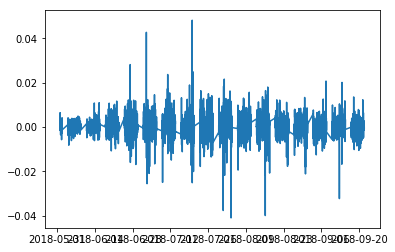

In [11]:
#观察价差
import matplotlib.pyplot as plt


plt.plot(dv15M.get_ts('gap', date_type='datetime')['USD_CNH:oanda'])#相当于观察这个东西的差价
plt.show()

## 3计算

MA20和MA55金叉死叉信号

`进场信号`：
long:如果出现，当20日均线向上穿过55日均线以及前一个小时的20日均线向下穿过55日均线时的信号时，赋值2表示做多，下多单。

short:如果出现，当20日均线向下穿过55日均线以及前一个小时的20日均线向上穿过55日均线时的信号时，赋值-2表示做空，下空单。

`出场信号`：
close_long：判断当前市场是否出现新的信号可以开空单，那么就平掉原来的多仓，否则继续持有多仓。赋值为1，表示平多仓。

close_short：判断当前市场是否出现新的信号可以开多单，那么就平掉原来的空仓，否则继续持有空仓。赋值为-1，表示平空仓。

In [1]:
# 进场信号
long = dv1H.add_formula("long",'If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)
short = dv1H.add_formula("short",'If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)
#alpha10 = dv.add_formula('alpha10_C','If(Ts_Min(Delta(close,1),4)>0,Delta(close,1),If((Ts_Max(Delta(close,1),4)<0),Delta(close,1),(-1*Delta(close,1))))',add_data=True)
# 出场信号
close_long = dv1H.add_formula("closeLong","If(short==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShort","If(long==2,-1,0)", add_data=True)

NameError: name 'dv1H' is not defined

In [12]:
dv1H.get_ts('long').stack()[dv1H.get_ts('long').stack()==2]#观察出现做多信号的时间点

trade_date      symbol       
20180607220000  USD_CNH:oanda    2.0
20180612160000  USD_CNH:oanda    2.0
20180614210000  USD_CNH:oanda    2.0
20180705180000  USD_CNH:oanda    2.0
20180710220000  USD_CNH:oanda    2.0
20180713180000  USD_CNH:oanda    2.0
20180717180000  USD_CNH:oanda    2.0
20180723180000  USD_CNH:oanda    2.0
20180726190000  USD_CNH:oanda    2.0
20180731050000  USD_CNH:oanda    2.0
20180801170000  USD_CNH:oanda    2.0
20180807010000  USD_CNH:oanda    2.0
20180809200000  USD_CNH:oanda    2.0
20180822160000  USD_CNH:oanda    2.0
20180829080000  USD_CNH:oanda    2.0
20180904150000  USD_CNH:oanda    2.0
20180907160000  USD_CNH:oanda    2.0
20180914140000  USD_CNH:oanda    2.0
dtype: float64

In [13]:
#通过测试报告，看多空信号的绩效，这里是定义报告格式
from jaqs_fxdayu.research import TimingDigger

tdMa = TimingDigger(output_folder=".", output_format='pdf',signal_name='Ma')

def TimingSignal(td, dv, long='long', short='short',closeLong='closeLong', closeShort='closeShort'\
                 , mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称

    #多空信号分别计算一遍 输出汇总结果
    td.process_signal(                        #long
        enter_signal=dv.get_ts(long),
        exit_signal=dv.get_ts(closeLong),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts('close'),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(                   #short
        enter_signal=dv.get_ts(short),
        exit_signal=dv.get_ts(closeShort),
        sig_type="short",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

In [14]:
TimingSignal(tdMa, dv1H, mhp=100, sl=0.05, sp=0.3)#调取数据

Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%


主要看的是win_ratio和win_mean/loss_mean,其他是基础的统计指标。
胜率win_ratio最好在0.4以上，盈亏比：win_mean/loss_mean在1以上，具体看两者比例。

In [15]:
tdMa.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              2.437  -4.674  -0.852
p-value             0.071   0.001   0.406
mean                0.005  -0.004  -0.001
std                 0.004   0.003   0.005
info_ratio          1.218  -1.349  -0.207
skewness           -0.061  -0.333   0.926
kurtosis           -1.742  -1.214   0.223
pct5                0.000  -0.008  -0.007
pct25               0.001  -0.006  -0.004
pct50               0.006  -0.003  -0.002
pct75               0.010  -0.002   0.000
pct95               0.010  -0.000   0.010
occurance           5.000  13.000  18.000
win_ratio             NaN     NaN   0.278
win_mean/loss_mean    NaN     NaN   1.521


In [16]:
tdMa.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                         win    loss     all
t-stat                   NaN  -8.571  -6.710
p-value                  NaN   0.000   0.000
mean                0.002000  -0.005  -0.004
std                 0.000000   0.002   0.003
info_ratio               inf  -2.213  -1.677
skewness            0.000000   0.000   0.517
kurtosis           -3.000000  -0.803  -0.018
pct5                0.002000  -0.008  -0.008
pct25               0.002000  -0.007  -0.007
pct50               0.002000  -0.004  -0.004
pct75               0.002000  -0.004  -0.004
pct95               0.002000  -0.001  -0.000
occurance           1.000000  16.000  17.000
win_ratio                NaN     NaN   0.059
win_mean/loss_mean       NaN     NaN   0.393


In [17]:
tdMa.create_event_report(sig_type="long_short") #同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              2.532  -9.093  -3.529
p-value             0.052   0.000   0.001
mean                0.005  -0.004  -0.003
std                 0.004   0.002   0.004
info_ratio          1.132  -1.718  -0.605
skewness            0.264  -0.041   1.344
kurtosis           -1.654  -1.066   1.869
pct5                0.000  -0.008  -0.008
pct25               0.001  -0.007  -0.006
pct50               0.004  -0.004  -0.004
pct75               0.009  -0.002  -0.001
pct95               0.010  -0.000   0.007
occurance           6.000  29.000  35.000
win_ratio             NaN     NaN   0.171
win_mean/loss_mean    NaN     NaN   1.133


## Alpha101

## Algotithm:
1. 文档：http://www.fxdayu.com/static/standalone/tutorials.html?article=245,

      https://jaqs.readthedocs.io/zh_CN/latest/user_guide.html#dataview
         
2. 源码查阅：Pycharm 

In [12]:
for dvAdd in [dv15M, dv1H]:
    dvAdd.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True)

In [13]:
import matplotlib.pyplot as plt

def Plot_Mean(dv, alpha, chart_name='dv_alpha_ma', ShortPeriod=20, LongPeriod=60, n=0):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
    ax.plot(dv.get_ts('close', date_type='datetime').iloc[:,0].iloc[n:])
    ax.set_title(chart_name,fontsize=24,color='b') 
    ax1.plot(alpha.iloc[n:], alpha=0.1)
    ax1.plot(pd.Series(alpha.rolling(ShortPeriod).mean(), index=alpha.index).iloc[n:])
    ax1.plot(pd.Series(alpha.rolling(LongPeriod).mean(), index=alpha.index).iloc[n:])
#     plt.savefig(chart_name)
    plt.show()

In [14]:
dv_dict = {'alpha1_dv15M':dv15M, 'alpha1_dv1H':dv1H}
alpha1_dict = {n: dv.get_ts('alpha1_C', date_type='datetime') for n, dv in dv_dict.items()}

In [15]:
# alpha1_dict

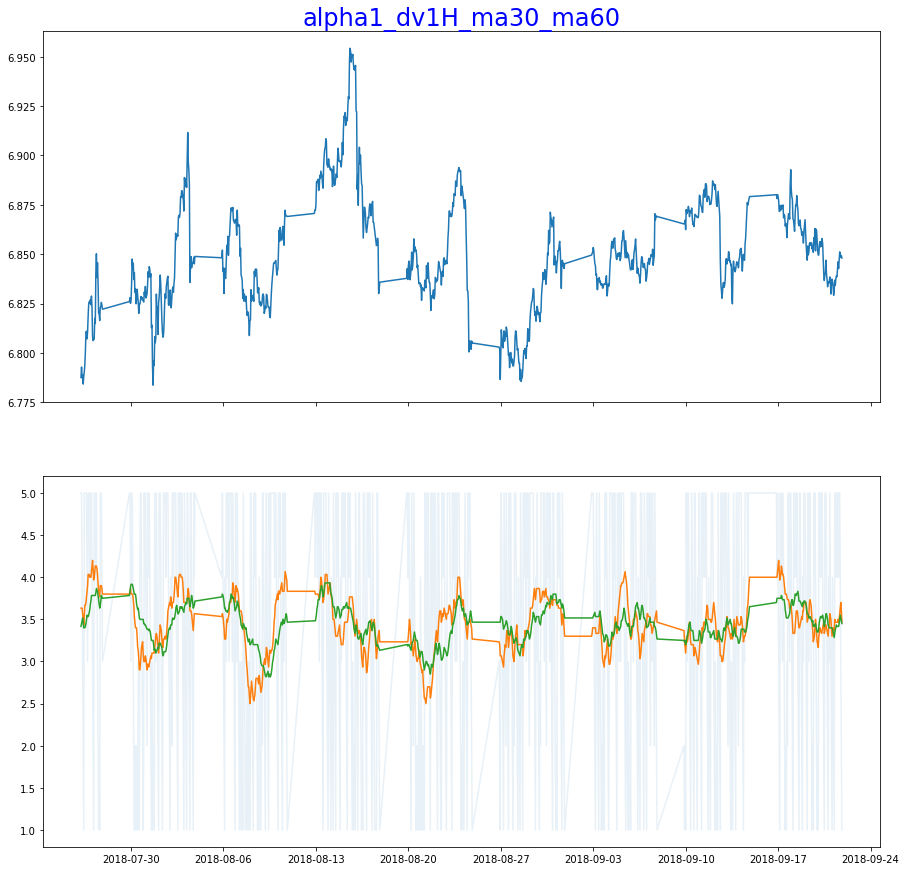

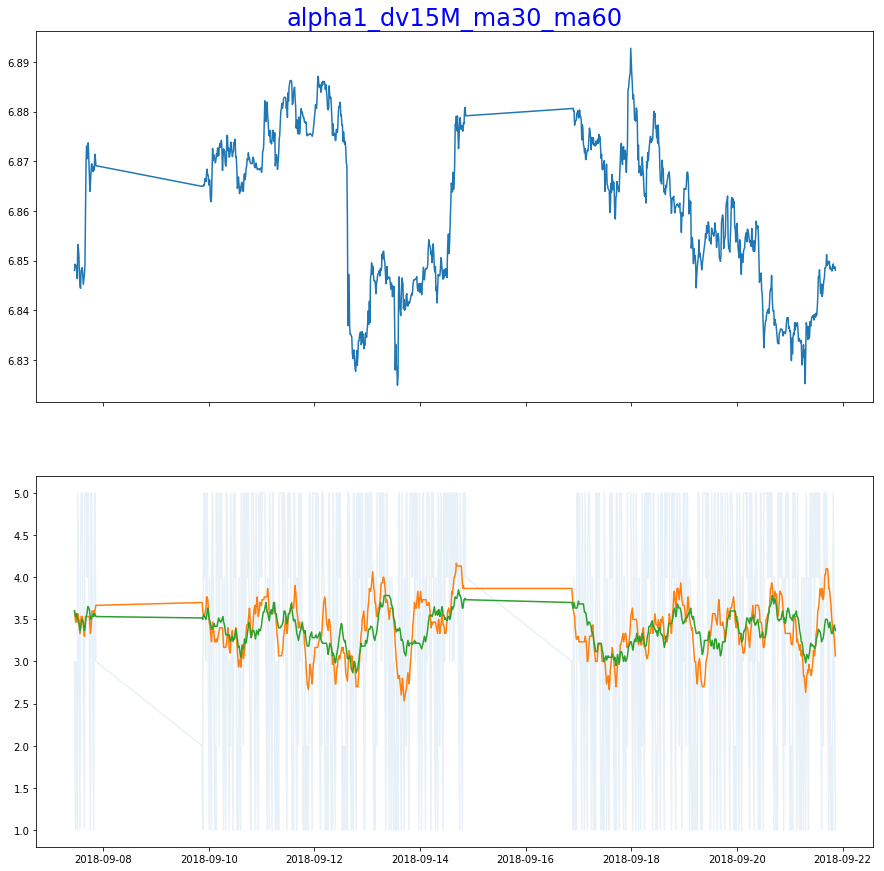

In [16]:
import pandas as pd
#alpha1_dv15M是15分钟线，1H是1小时线，ma30和ma60代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha1_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma30_ma60',ShortPeriod=30, LongPeriod=60, n=-1000)#橘色短线 绿色长线

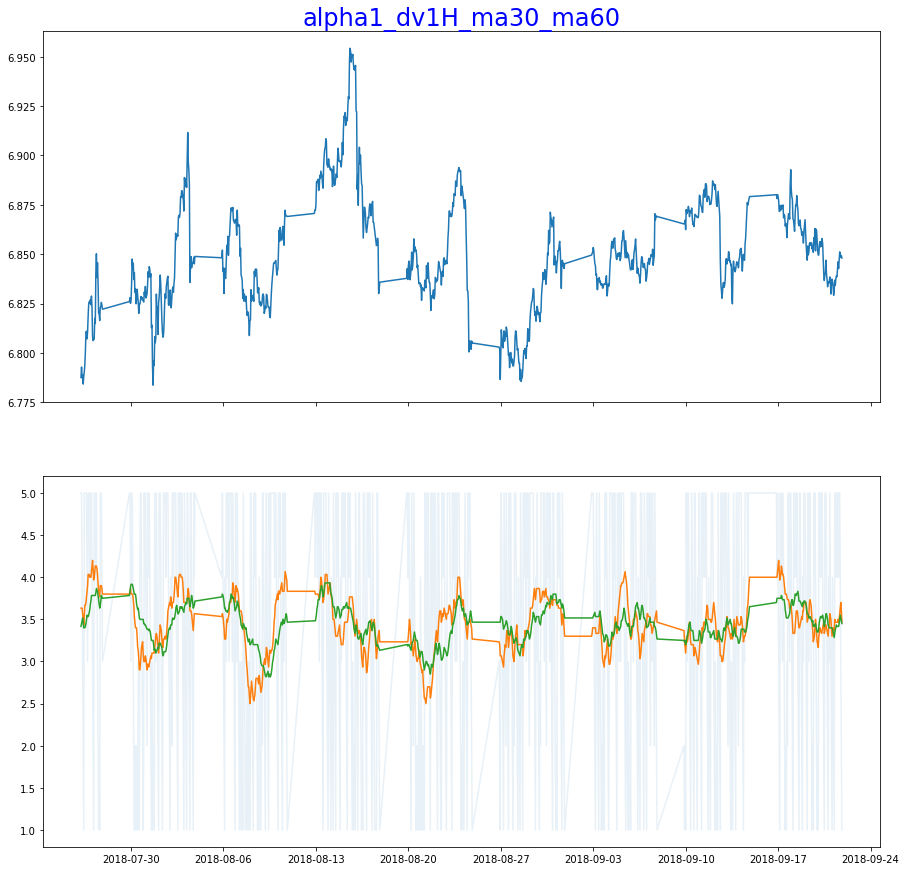

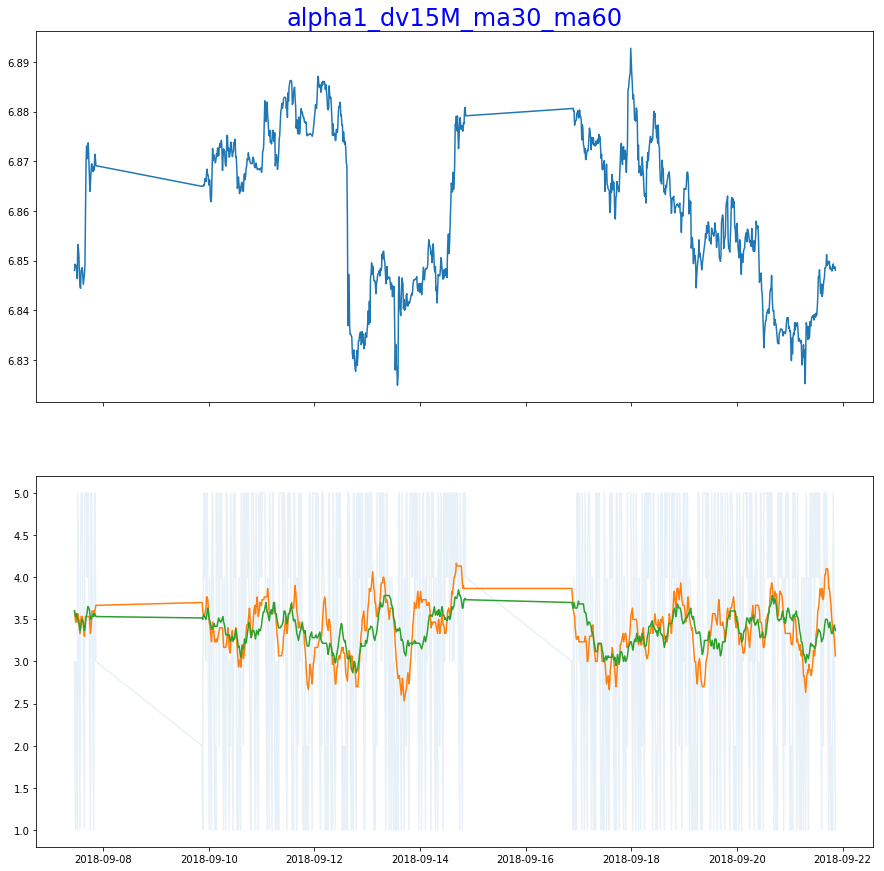

In [18]:
import pandas as pd
#alpha1_dv15M是15分钟线，1H是1小时线，ma30和ma60代表对信号进行均线处理和观察是否与价格存在涨跌关系
for name, alpha in alpha1_dict.items():
    Plot_Mean(globals()[name.split('_')[1]], alpha.iloc[:,0], chart_name=name+'_ma30_ma60',ShortPeriod=30, LongPeriod=60, n=-1000)#橘色短线 绿色长线

In [23]:
# 进场信号
long = dv1H.add_formula("longAlpha1","If((Ts_Mean(alpha1_C,20)>Ts_Mean(alpha1_C,55)) && (Delay(Ts_Mean(alpha1_C,20),1)<=Delay(Ts_Mean(alpha1_C,55),1)),2,0)", add_data=True)
short = dv1H.add_formula("shortAlpha1","If((Ts_Mean(alpha1_C,20)<Ts_Mean(alpha1_C,55)) && (Delay(Ts_Mean(alpha1_C,20),1)>=Delay(Ts_Mean(alpha1_C,55),1)),-2,0)", add_data=True)

# 出场信号
close_long = dv1H.add_formula("closeLongAlpha1","If(shortAlpha1==-2,1,0)", add_data=True)
close_short = dv1H.add_formula("closeShortAlpha1","If(longAlpha1==2,-1,0)", add_data=True)

In [24]:
dv1H.get_ts('longAlpha1').stack()[dv1H.get_ts('longAlpha1').stack()==2].tail()

trade_date      symbol       
20180919100000  USD_CNH:oanda    2.0
20180919160000  USD_CNH:oanda    2.0
20180920120000  USD_CNH:oanda    2.0
20180921080000  USD_CNH:oanda    2.0
20180921140000  USD_CNH:oanda    2.0
dtype: float64

In [25]:
from jaqs_fxdayu.research import TimingDigger

tdAlpha1 = TimingDigger(output_folder=".", output_format='pdf',signal_name='Alpha001')

TimingSignal(tdAlpha1, dv1H,'longAlpha1','shortAlpha1','closeLongAlpha1','closeShortAlpha1', 100, 0.05, 0.3)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 1%


观察有无加入alpha的绩效区别

主要看的是win_ratio和win_mean/loss_mean,其他是基础的统计指标。
胜率win_ratio最好在0.4以上，盈亏比：win_mean/loss_mean在1以上，具体看两者比例。

In [26]:
tdAlpha1.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                       win     loss      all
t-stat               6.496  -12.362   -1.690
p-value              0.000    0.000    0.093
mean                 0.003   -0.002   -0.000
std                  0.003    0.002    0.003
info_ratio           0.968   -1.184   -0.136
skewness             1.394   -2.036    1.319
kurtosis             1.545    5.004    3.949
pct5                 0.000   -0.005   -0.004
pct25                0.000   -0.002   -0.002
pct50                0.002   -0.001   -0.001
pct75                0.005   -0.001    0.000
pct95                0.010   -0.000    0.006
occurance           46.000  110.000  156.000
win_ratio              NaN      NaN    0.295
win_mean/loss_mean     NaN      NaN    1.626


In [27]:
tdMa.create_event_report(sig_type="long_short")

*****-Summary-*****
Event Analysis
                      win    loss     all
t-stat              2.532  -9.093  -3.529
p-value             0.052   0.000   0.001
mean                0.005  -0.004  -0.003
std                 0.004   0.002   0.004
info_ratio          1.132  -1.718  -0.605
skewness            0.264  -0.041   1.344
kurtosis           -1.654  -1.066   1.869
pct5                0.000  -0.008  -0.008
pct25               0.001  -0.007  -0.006
pct50               0.004  -0.004  -0.004
pct75               0.009  -0.002  -0.001
pct95               0.010  -0.000   0.007
occurance           6.000  29.000  35.000
win_ratio             NaN     NaN   0.171
win_mean/loss_mean    NaN     NaN   1.133
